In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import mat73
import scipy.io as spio
import scipy.stats as sp
import mat73
import seaborn as sns
from scipy.special import factorial
from scipy.special import logsumexp
import pandas as pd
from replay_structure.utils import get_marginal_sum

from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# import numerical libraries
import numpy as np
import scipy.interpolate
import os
import pickle

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import yaml

# Fklab-python-core tool 
#-----------------------

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# Py-compressed-kde package
# -------------------------

# finally, import the decoding tools
import compressed_kde
from compressed_kde import decode



ImportError: Numba needs NumPy 1.24 or less

In [5]:
RESULTS_PATH = "/home/katharina/Documents/Studium/MIT/project/data/y_maze/"
lp = mat73.loadmat(RESULTS_PATH+'linearPos.mat')
vel = mat73.loadmat(RESULTS_PATH+'linearVel.mat')
sp = mat73.loadmat(RESULTS_PATH+'spks.mat')
stim = mat73.loadmat(RESULTS_PATH+'stim.mat')

In [5]:
lp['lPos']['run1']

{'arm1': array([ True,  True,  True, ...,  True,  True,  True]),
 'arm2': array([False, False, False, ..., False, False, False]),
 'commonStem': array([False, False, False, ..., False, False, False]),
 'data': array([-126.80859581, -126.80859581, -126.80859581, ..., -126.80859581,
        -126.80859581, -126.80859581]),
 'timestamp': array([4130.39275   , 4130.46055594, 4130.49383594, ..., 4954.50509994,
        4954.53940394, 4954.57217194])}

In [6]:
vel

{'lVel': {'run1': {'data': array([0., 0., 0., ..., 0., 0., 0.]),
   'timestamp': array([4130.39275   , 4130.46055594, 4130.49383594, ..., 4954.50509994,
          4954.53940394, 4954.57217194])},
  'run2': {'data': array([ 548.03008256,  540.76751879,  521.82524909, ..., -349.70956581,
          -301.3745463 , -245.24789121]),
   'timestamp': array([7433.883822  , 7433.917614  , 7433.950894  , ..., 8407.47303594,
          8407.50682794, 8407.53959594])},
  'run3': {'data': array([ 114.69671938,  280.76046645,  437.33966138, ..., -398.39552319,
          -189.42805435,    0.        ]),
   'timestamp': array([11068.05441194, 11068.08820394, 11068.12097194, ...,
          11929.35309994, 11929.38586794, 11929.41965994])},
  'run4': {'data': array([0., 0., 0., ..., 0., 0., 0.]),
   'timestamp': array([14548.73178794, 14548.76557994, 14548.79732394, ...,
          15449.23636394, 15449.26913194, 15449.30292394])}}}

In [6]:
runs = ['run2', 'run3', 'run4']

veldata = vel['lVel']['run1']['data']
veltime = vel['lVel']['run1']['timestamp']

for run in runs:
    veldata = np.append(veldata, vel['lVel'][run]['data'])
    veltime = np.append(veltime, vel['lVel'][run]['timestamp'])

In [7]:
run1 = (vel['lVel']['run1']['timestamp'][0], vel['lVel']['run1']['timestamp'][-1])
run1

(4130.3927500005775, 4954.572171935255)

In [8]:
pos_bw = 5  # cm, default spatial kernel bandwidth
amp_bw = 0.00004  # default spike amplitude kernel bandwidth
compression = 0.5 # kernel density compression Mahalanobis distance threshold

stim_sampling_frequency = 30.0  # Hz, sampling frequency of position tracking
speed_threshold = 15.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

decode_bin = 0.2  # seconds, bin size for run decoding

In [9]:
tt_amp = [resp[ix][:,:-1] for resp, ix in zip(sp['sp']['response'], sp['sp']['ix'])]
tt_time = [time[ix] for time, ix in zip(sp['sp']['timestamp'], sp['sp']['ix'])]
tt_pos = [pos[ix] for pos, ix in zip(sp['sp']['stimuluslinpos'], sp['sp']['ix'])]
tt_pos = [p.reshape(p.shape[0],1) for p in tt_pos]

speed = abs(veldata)
stimtime = stim['stimulus']['timestamp']
pos = stim['stimulus']['linearpos']

In [10]:
linear_pos_interpolator = scipy.interpolate.interp1d(
    stim['stimulus']['timestamp'], pos, kind="nearest", bounds_error=False
)

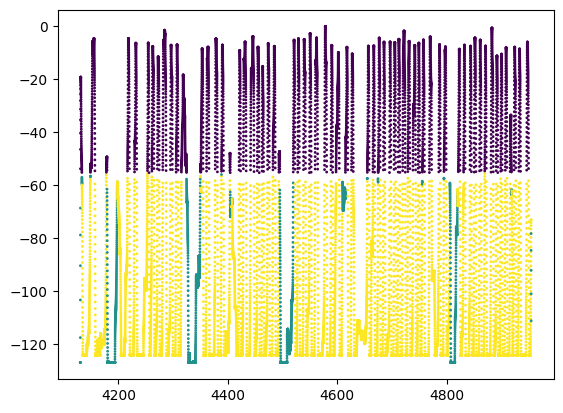

In [11]:
plt.scatter(stim['stimulus']['timestamp'][:24920],stim['stimulus']['linearpos'][:24920],  c=stim['stimulus']['armID'][:24920], s=1)

In [12]:
x = np.linspace(0, -126.9, 30)
stim['stimulus']['linearpos'][:24920].min()

-126.80859580679245

In [13]:
lin_space = compressed_kde.EuclideanSpace(
    ['x'],      # list of labels for all dimensions
    kernel=compressed_kde.GaussianKernel(),  # desired kernel
    bandwidth=[5]     # list of bandwidths for all dimensions
)
lin_grid = lin_space.grid(
    [x],  # list of coordinate vectors for all dimensions
)

In [14]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        abs(speed[:]) > speed_threshold, stimtime
    )

In [15]:
# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = compressed_kde.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)], bandwidth=[amp_bw,] * 4
)

In [16]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus, event_data in zip(
            kwargs["event_time"], kwargs["event_stimulus"], kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            L = decode.PoissonLikelihood(kwargs["event_space"], stim)
            L.add_events(
                np.concatenate(
                    (event_data[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)

        # build decoder from likelihoods
        decoder = decode.Decoder(likelihoods, [])

        return decoder, likelihoods

    return fcn

In [17]:
data = dict(stimulus_space = lin_space,
            grid = lin_grid,
            stimulus_duration = 1./stim_sampling_frequency,
            compression = compression,
            stimulus = pos,
            stimulus_time = stimtime,
            event_time = tt_time,
            event_data = tt_amp,
            event_stimulus = tt_pos,
            event_space = spike_space,
           )

build_decoder = decoder_build_factory(**data)

In [97]:
np.concatenate((tt_amp[0], tt_pos[0]), axis=1).shape

(232861, 5)

In [18]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s], :]
                for x, b in zip(kwargs["event_data"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [19]:
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=tt_amp)

build_data = data_build_factory(**data)

In [20]:
np.linspace(run1[0] ,run1[1], 6)

array([4130.39275   , 4295.22863439, 4460.06451877, 4624.90040316,
       4789.73628755, 4954.57217194])

In [21]:
segemnts = [[4130.39275, 4295.22863439], [4295.22863439, 4460.06451877], [4460.06451877, 4624.90040316], [4624.90040316, 4789.73628755],[4789.73628755, 4954.57217194]]

In [22]:
trials = fklab.segments.Segment(
   segemnts
)
ntrials = len(trials)

In [23]:
# create lists for collecting real position, estimates and errors
reals = []
estimates = []
errors = []
posteriors = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):
    print(test_trial)

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder, likelihoods = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)
    posteriors.append(posterior)

    # compute MAP estimates
    estimates.append(lin_grid.points().squeeze()[np.argmax(posterior, axis=1)])
    # determine real stimulus values
    reals.append(linear_pos_interpolator(decode_segments.center))
    # compute errors
    errors.append(
        abs(estimates[-1]-reals[-1]))

estimates = np.concatenate(estimates)
reals = np.concatenate(reals)
errors = np.concatenate(errors)

0
1
2
3
4


In [24]:
lin_grid.points().squeeze()

array([   0.        ,   -4.37586207,   -8.75172414,  -13.12758621,
        -17.50344828,  -21.87931034,  -26.25517241,  -30.63103448,
        -35.00689655,  -39.38275862,  -43.75862069,  -48.13448276,
        -52.51034483,  -56.8862069 ,  -61.26206897,  -65.63793103,
        -70.0137931 ,  -74.38965517,  -78.76551724,  -83.14137931,
        -87.51724138,  -91.89310345,  -96.26896552, -100.64482759,
       -105.02068966, -109.39655172, -113.77241379, -118.14827586,
       -122.52413793, -126.9       ])

In [25]:
posteriors[0].shape

(226, 30)

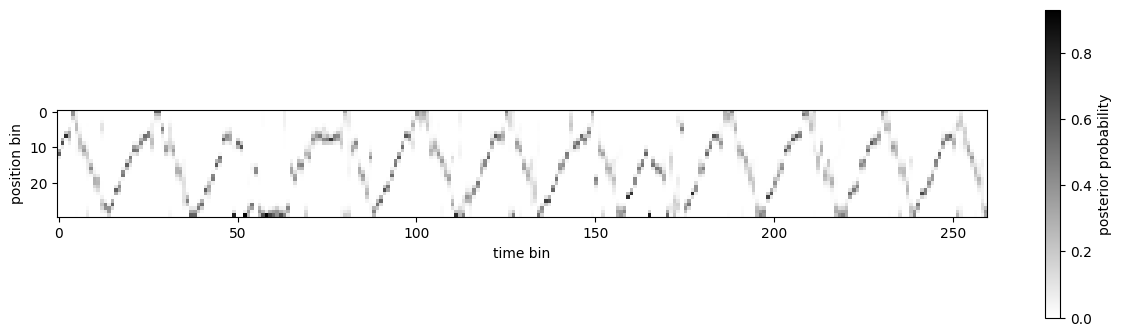

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[1].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

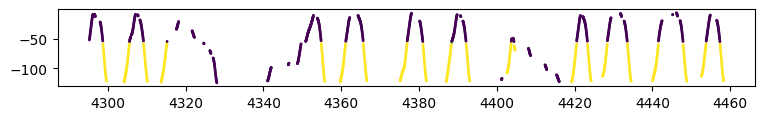

In [132]:
test_epochs = run_epochs.intersection(trials[1])
plt.figure(figsize=(9,1))
for start, stop in zip(test_epochs.start, test_epochs.stop):
    IND = np.where((stim['stimulus']['timestamp']>start) & (stim['stimulus']['timestamp']<stop))[0]
    if len(IND)>2:
        plt.scatter(stim['stimulus']['timestamp'][IND[0]:IND[-1]], stim['stimulus']['linearpos'][IND[0]:IND[-1]],  c=stim['stimulus']['armID'][IND[0]:IND[-1]], s=1)

test_epochs# test decoder

In [27]:
# extract event data for each time bin
decode_segments, data = build_data(trials[0])

posterior = [decoder.decode(x, decode_bin, True) for x in data]
posterior = np.vstack(posterior)

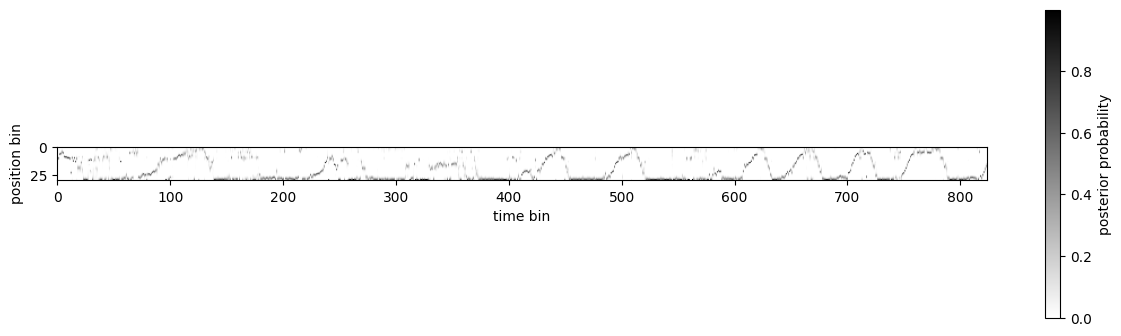

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posterior.T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

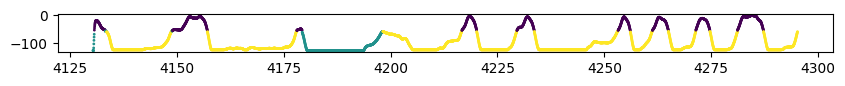

In [147]:
plt.figure(figsize=(10,0.5))
plt.scatter(stim['stimulus']['timestamp'][:4982],stim['stimulus']['linearpos'][:4982],  c=stim['stimulus']['armID'][:4982], s=1)

In [141]:
trials[0]

Segment(array([[4130.39275   , 4295.22863439]]))

In [143]:
np.where(stim['stimulus']['timestamp']<4295.22863439)

(array([   0,    1,    2, ..., 4980, 4981, 4982]),)

In [ ]:
# extract event data for each time bin
decode_segments, data = build_data(trials[0])

posterior = [decoder.decode(x, decode_bin, True) for x in data]

In [165]:
len(tt_amp)

7

In [167]:
trials[0]

Segment(array([[4130.39275   , 4295.22863439]]))

In [177]:
len(tt_time)

7

In [179]:
likelihoods

In [30]:
posteriors[0].shape

(226, 30)

In [32]:
selection = trials[0].contains(tt_time[0])[0]
selection.shape

(232861,)

In [43]:
tt_amp[0][selection][0].reshape(1,4)

array([[6.54558698e-05, 5.56863370e-05, 4.03807356e-05, 7.84819136e-05]])

In [84]:
data[90][3]

array([[6.91531327e-05, 8.19314290e-05, 6.20123201e-05, 6.84014682e-05],
       [3.13444091e-04, 1.66117851e-04, 1.33420446e-04, 7.14081262e-05],
       [6.76498037e-05, 1.46574575e-05, 9.35822285e-05, 2.63082570e-05],
       [2.22868520e-04, 1.11622176e-04, 1.51836226e-04, 1.12749673e-04],
       [6.76498037e-06, 1.65366187e-05, 3.90865533e-05, 7.62939453e-05],
       [7.85489388e-05, 9.84680476e-05, 7.85489388e-05, 1.11998008e-04],
       [2.66840892e-05, 2.21741023e-05, 4.54757014e-05, 7.70456098e-05],
       [5.56231720e-05, 5.14890173e-05, 5.11131850e-05, 7.59181131e-05],
       [3.50651483e-04, 2.25123514e-04, 2.13848546e-04, 1.48829568e-04],
       [7.62939453e-05, 6.72739715e-05, 7.40389519e-05, 7.70456098e-05],
       [7.93006033e-05, 7.21597906e-05, 6.72739715e-05, 6.20123201e-05],
       [9.24547318e-05, 7.44147841e-05, 7.51664486e-05, 6.16364878e-05],
       [7.21597906e-05, 8.90722416e-05, 4.58515336e-05, 7.40389519e-05]])

In [85]:
len(data)

824

In [86]:
len(data[90])

7

In [87]:
data[90][0]

array([[1.04859652e-04, 7.97845180e-05, 6.08967545e-05, 5.11272217e-05],
       [1.25050020e-04, 1.09418768e-04, 7.00149852e-05, 9.63927238e-05],
       [9.70440259e-05, 9.34618639e-05, 8.04358202e-05, 6.70841253e-05],
       [6.25250100e-05, 6.77354275e-05, 1.08441814e-04, 4.26602933e-05]])

In [69]:
trials[0]

Segment(array([[4130.39275   , 4295.22863439]]))

In [66]:
# extract event data for each time bin
_, data = build_data(trials[0])  # Segment(array([[4130.39275   , 4295.22863439]]))
# data: for each time bin 7 tetrode arrays

Ls = []
for i in range(7):
    selection = trials[0].contains(tt_time[i])[0]
    # likelihood[i] of electrode i with data x[i] of electrode i
    L = [likelihoods[i].likelihood(x[i], decode_bin) for x in data]
    # L = likelihoods[i].likelihood(tt_amp[i][selection], decode_bin)
    Ls.append(L)

In [70]:
np.array(Ls).shape

(7, 824, 30)

<ipython-input-79-7b0cdb2c6ea2>:4: RuntimeWarning: invalid value encountered in log
  marginal_plot = np.log(marginal_norm)
<ipython-input-79-7b0cdb2c6ea2>:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(img, label="posterior probability")


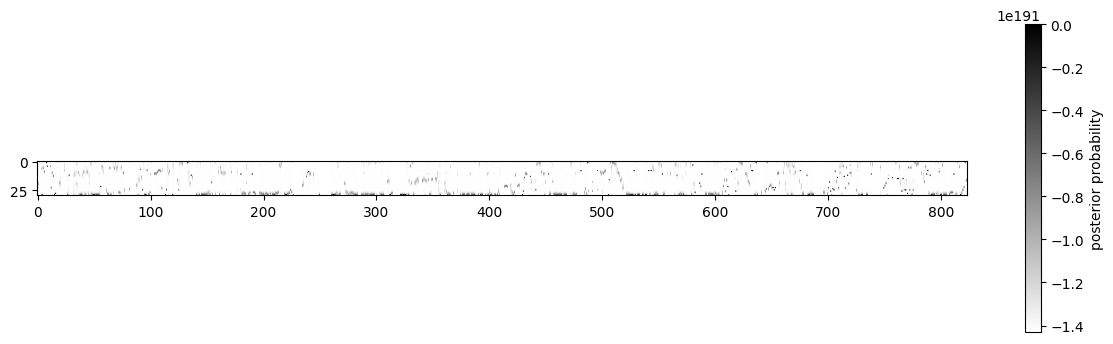

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
likelihood_m = np.prod(np.array(Ls), axis=0)
marginal_norm = likelihood_m.T / np.sum(likelihood_m.T, axis=0)
marginal_plot = np.log(marginal_norm)
fig = ax.imshow(marginal_norm, cmap="gray_r")
plt.colorbar(img, label="posterior probability")